In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
%matplotlib inline

In [2]:
grace = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/GRACE/GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc')

In [42]:
lon_in = np.where((grace.lon > 260) & (grace.lon < 280))[0]
lat_in = np.where((grace.lat > 20) & (grace.lat < 30))[0]

In [82]:
latis = [5,12,5,12,5,12]
lonis = [11,11,20,20,26,26]
gommean = grace.lwe_thickness[:,lat_in[latis],lon_in[lonis]].mean(dim=['lat','lon'])
gom_a = gommean - gommean.mean(dim='time')
gbp_a = gom_a.polyfit(dim='time', deg=1)
gbp_a_trend = xr.polyval(gom_a['time'], gbp_a.polyfit_coefficients)
gbp_a_detrend = gom_a - gbp_a_trend

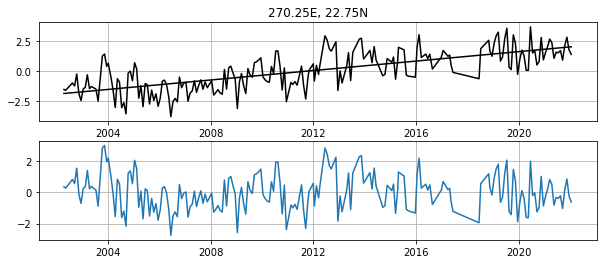

In [85]:
loni = 20; lati = 5;
loni_2 = 20; lati_2 = 12;
loni_3 = 11; lati_3 = 5;
loni_4 = 11; lati_4 = 12;
loni_5 = 26; lati_5 = 5;
loni_6 = 26; lati_6 = 12;
f, (ax,ax2) = plt.subplots(2,1,figsize=(10,4))
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati],lon_in[loni]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_2],lon_in[loni_2]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_3],lon_in[loni_3]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_4],lon_in[loni_4]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_5],lon_in[loni_5]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_6],lon_in[loni_6]])
ax.plot(grace.time,gom_a,color='k')
ax.plot(grace.time,gbp_a_trend,color='k')
ax.set_title(str(grace.lon[lon_in[loni]].data) + 'E, ' + str(grace.lat[lat_in[lati]].data) + 'N')
ax.grid()

ax2.plot(grace.time,gbp_a_detrend)
ax2.grid()

(-100.0, -50.0)

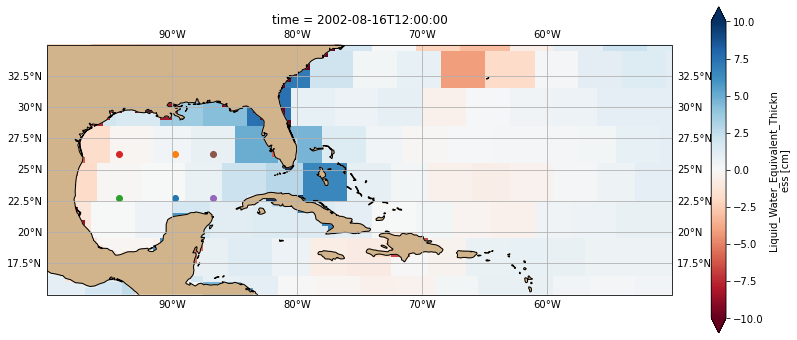

In [61]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
tests = grace.lwe_thickness[2]
tests.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap=plt.get_cmap('RdBu'))
ax.scatter(grace.lon[lon_in[loni]], grace.lat[lat_in[lati]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_2]], grace.lat[lat_in[lati_2]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_3]], grace.lat[lat_in[lati_3]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_4]], grace.lat[lat_in[lati_4]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_5]], grace.lat[lat_in[lati_5]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_6]], grace.lat[lat_in[lati_6]],transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); 
ax.set_ylim([15,35]); ax.set_xlim([-100,-50])